In [2]:
!kaggle datasets download -d martaarroyo/palmer-penguins-for-binary-classification

Dataset URL: https://www.kaggle.com/datasets/martaarroyo/palmer-penguins-for-binary-classification
License(s): Attribution 4.0 International (CC BY 4.0)




  0%|          | 0.00/2.42k [00:00<?, ?B/s]
100%|██████████| 2.42k/2.42k [00:00<00:00, 495kB/s]


In [2]:
import numpy as np
import pandas as pd
import math

In [3]:
data = pd.read_csv("palmer-penguins-for-binary-classification/penguins_binary_classification.csv")

Simplificamos el dataset para estar ante un problema de clasificación binaria

In [4]:


# data es nuestro dataset -> data = pd.read_csv('penguins_binary_classification.csv')

X = data[['bill_length_mm','bill_depth_mm']].to_numpy() # Transformamos el dataset a una matriz Numpy

La columna que queremos clasificar es la especie del pingüino (species), que es una columna de texto.

Como el modelo de regresión logística únicamente admite variables numéricas primero tendremos que codificarla:

In [5]:
y = pd.get_dummies(data['species'], drop_first= True)

# y = 0 -> Adelie
# y = 1 -> Gentoo

y = y['Gentoo'].to_numpy()

Exploración de los datos


Vamos a ver los primeros elementos de nuestro dataset y cerciorarnos de que son arrays de Numpy:

In [6]:
print("Primeros 5 elementos de nuestro dataset:\n", X[:5])
print("Tipo de X:",type(X))

Primeros 5 elementos de nuestro dataset:
 [[39.1 18.7]
 [39.5 17.4]
 [40.3 18. ]
 [36.7 19.3]
 [39.3 20.6]]
Tipo de X: <class 'numpy.ndarray'>


In [7]:
print("Primeros 5 elementos del vector de etiquetas:\n", y[:5])
print("Tipo de y:",type(y))

Primeros 5 elementos del vector de etiquetas:
 [False False False False False]
Tipo de y: <class 'numpy.ndarray'>


También es importante tener claras las dimensiones de los datos con los que estamos trabajando y cuantas observaciones tenemos:

In [8]:
print ('Las dimensiones de X son: ' + str(X.shape))
print ('Las dimensiones de y son: ' + str(y.shape))
print ('Tenemos m = %d muestras de entrenamiento' % (len(y)))

Las dimensiones de X son: (274, 2)
Las dimensiones de y son: (274,)
Tenemos m = 274 muestras de entrenamiento


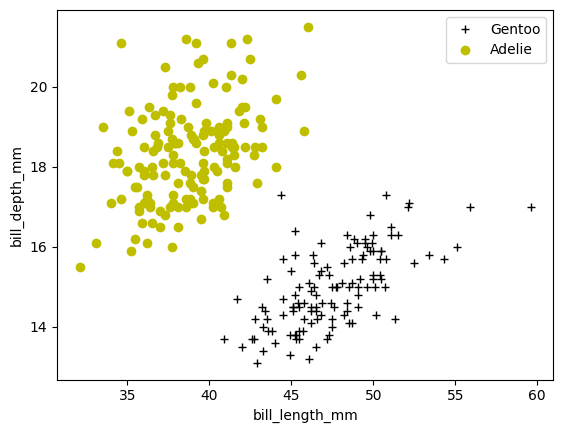

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# Buscamos los índices en los que la etiqueta es positiva y negativa
pos = y == 1
neg = y == 0

#Representamos los pingüinos
plt.plot(X[pos, 0], X[pos, 1], 'k+', label="Gentoo")
plt.plot(X[neg, 0], X[neg, 1], 'yo', label="Adelie")

# Etiqueta eje y
plt.ylabel('bill_depth_mm')
# Etiqueta eje X
plt.xlabel('bill_length_mm')
plt.legend(loc="upper right")
plt.show()

Regresión logística 1: a mano

Únicamente utilizando la librería de Numpy.

Para ello vamos a seguir los siguientes pasos:

Definir la función sigmoide
Definir la función de coste que se utiliza en regresión logística
Definir una función que calcule el gradiente de la función de coste
Construir el algoritmo de descenso de gradiente
Juntar todos los pasos

Función sigmoide
Hemos hablado antes de la importancia de la función sigmoide.




In [20]:
def sigmoid(z):
    """
    Calcula la función sigmoide de z

    Args:
        z (ndarray): Un escalar o numpy array de cualquier tamaño.

    Devuelve:
        g (ndarray): sigmoid(z), del mismo tamaño que z

    """

    g = 1 / (1 + np.exp(-z))

    return g

 Medir el error del modelo
En regresión logística medimos el error que comete el modelo en cada observación con la siguiente función de error:

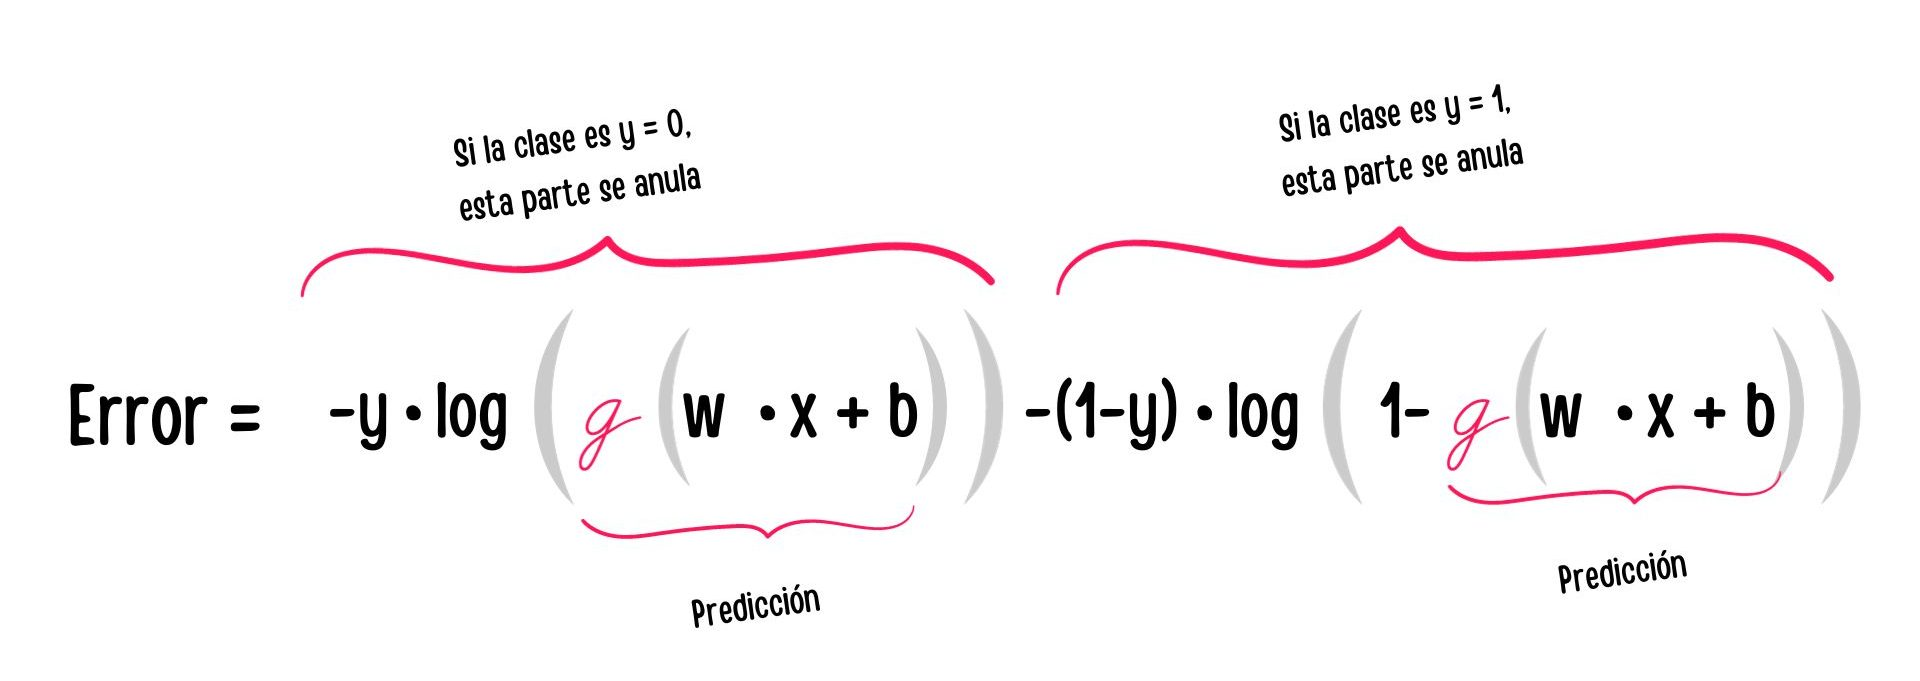

Lo que representa es que si la etiqueta pertenece a la clase y=1 y la predicción es una probabilidad pequeña, el logaritmo de un número muy cercano a cero es una magnitud grande pero negativa.

Y cuánto más cercano a cero, mayor será la magnitud del logaritmo (pero será negativo, por eso tenemos el signo menos delante)

La función de coste suma el error obtenido por el modelo en todas las observaciones.

A continuación verás cómo hacerlo utilizando vectorización.

Si no te queda claro cómo funciona puedes ver más pasos intermedios (utilizando bucles for) en el tutorial de regresión lineal.

In [21]:
def funcion_coste(X, y, w, b):
    """
    Calcula el valor de la función de coste en un modelo de regresión logística.
    Args:
      X : (ndarray dimensiones (m,n)) datos de entrenamiento, m observaciones con n características
      y : (ndarray dimensiones (m,))  salida del modelo
      w : (ndarray dimensiones (n,))  Parámetros del modelo
      b : (escalar)              Parámetro de sesgo del modelo
    Returns:
      coste_total : (escalar) coste
    """

    m, n = X.shape
    coste_total = np.sum(-y * np.log(sigmoid(np.dot(X, w) + b)) - (1 - y) * np.log(1 - sigmoid(np.dot(X,w) + b)))/m

    return coste_total

##Conseguir que el error sea lo más pequeño posible


Si conseguimos reducir todo lo que podamos la función de coste habremos conseguido ajustar los coeficientes de nuestro modelo de manera óptima a los datos que tenemos.

Entonces, para poder optimizar la función de coste usaremos el algoritmo de descenso del gradiente.

Este algoritmo es capaz de calcular de manera iterativa un mínimo de la función de coste.

Cálculo del gradiente
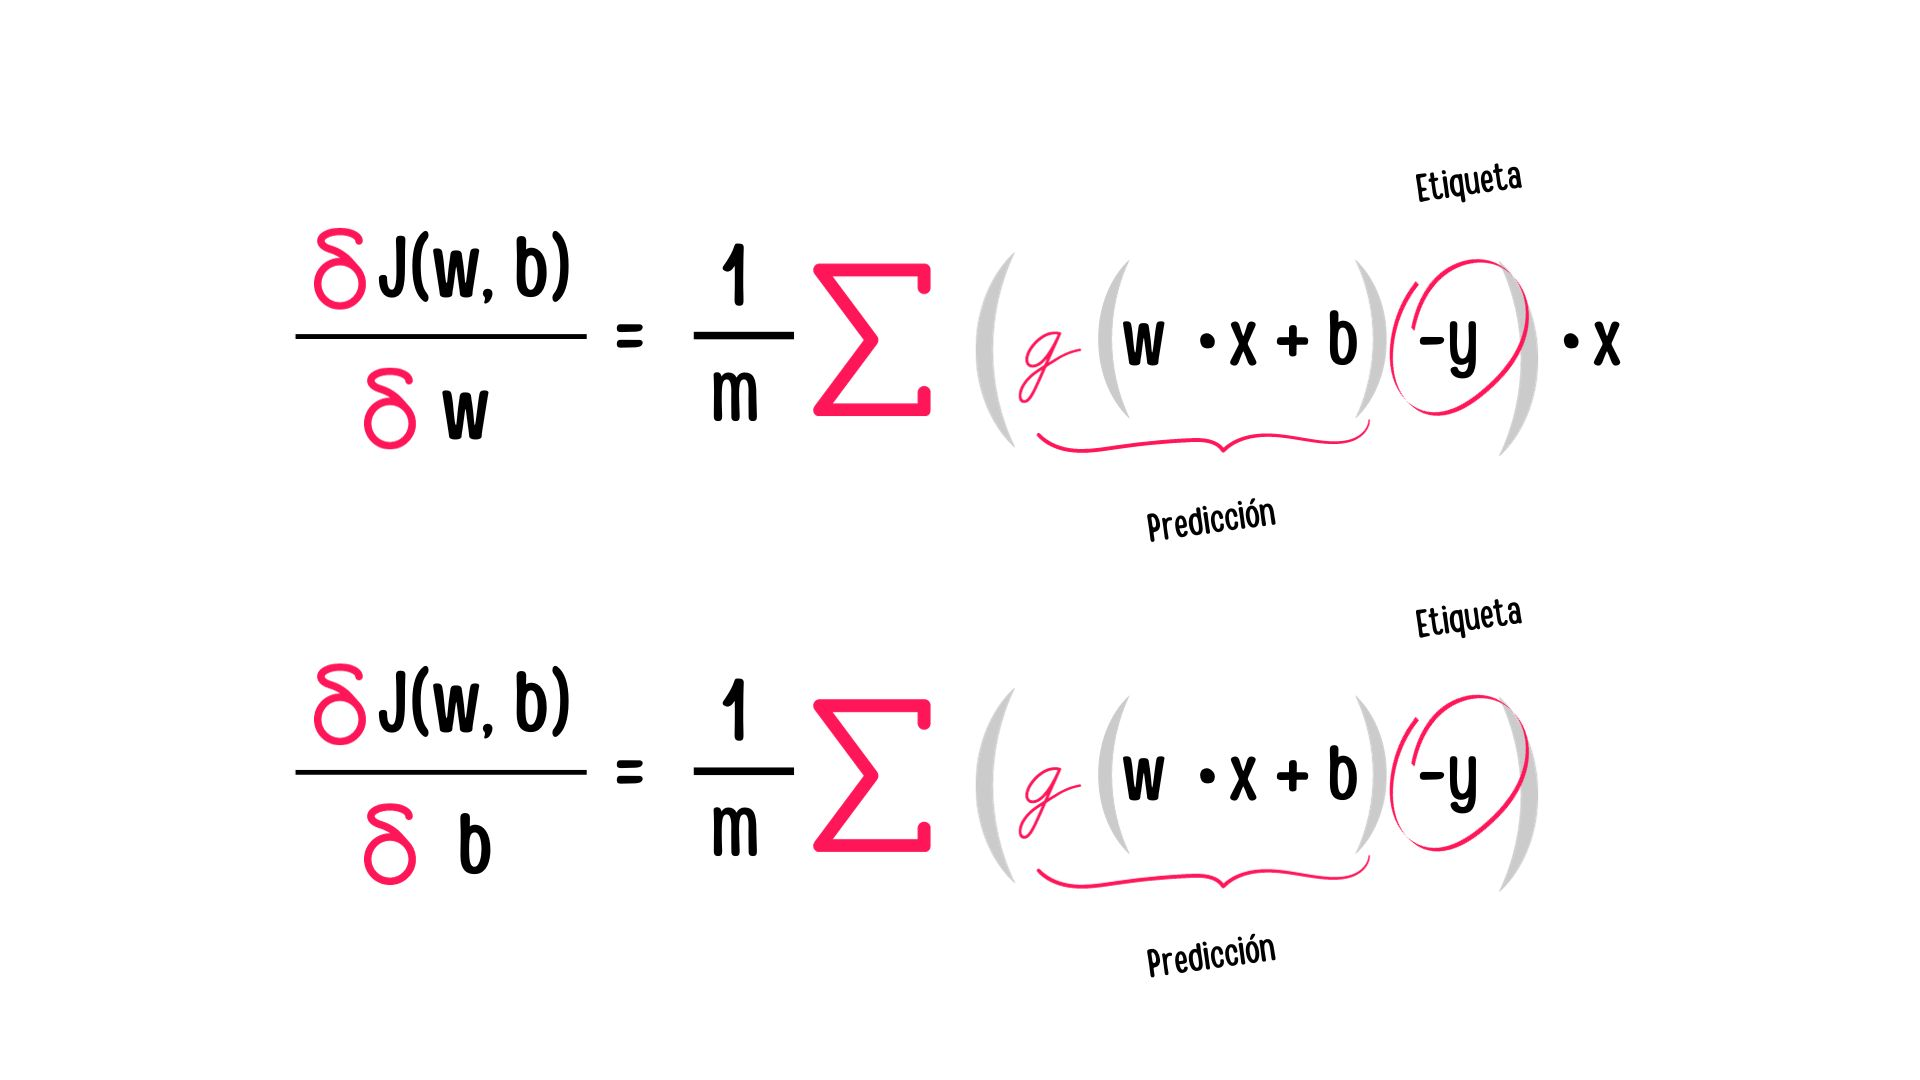

In [22]:
def calcula_gradiente(X, y, w, b):
    """
    Calcula el gradiente en un modelo de regresión logística.

    Argumentos:
      X : (ndarray dimensiones (m,n)) datos de entrenamiento, m observaciones con n características
      y : (ndarray dimensiones (m,))  salida del modelo
      w : (ndarray dimensiones (n,))  Parámetros del modelo
      b : (escalar)              Parámetro de sesgo del modelo
    Devuelve:
      grad_w : (ndarray Shape (n,)) Gradiente de la función de coste con respecto a w
      grad_b : (escalar)            Gradiente de la función de coste con respecto al parámetro b.
    """
    m, n = X.shape
    grad_w = np.zeros(w.shape)
    grad_b = 0.

    grad_w = np.dot((sigmoid(np.dot(X, w) + b) - y), X)/m
    grad_b = np.sum(sigmoid(np.dot(X, w) + b) - y)/m


    return grad_b, grad_w

Optimización del modelo


El algoritmo de descenso de gradiente es el mismo que para el casi de la regresión lineal:

Calculamos el gradiente
Actualizamos los coeficientes del modelo gracias al hiperparámetro alpha
Repetimos el número de veces que decidamos

In [23]:
def descenso_gradiente(X, y, w_in, b_in, funcion_coste, calcula_gradiente, alpha, num_iters):
    """
    Algoritmo del descenso de gradiente para ajustar los coeficientes del model: w1,w0. 
    Actualiza w,b ejecutando los pasos del algoritmo num_iters veces con un learning rate de alpha

    Args:
      X : (ndarray dimensiones (m,n)) datos de entrenamiento, m observaciones con n características
      y : (ndarray dimensiones (m,))  salida del modelo
      w_in : (ndarray Shape (n,))  Valores iniciales de los coeficientes w del modelo
      b_in : (escalar)             Valor inicial del coeficiente del modelo b
      cost_function :              Función que calcula el coste
      gradient_function :          Función que calcula el gradiente 
      alpha : (float)              Learning rate
      num_iters : (escalar)        Número de veces que se ejecutan los pasos del descenso de gradiente

    Returns:
      w : (ndarray dimensiones (n,)) Coeficiente actualizado después del descenso de gradiente
      b : (escalar)                  Coeficiente actualizado después del descenso de gradiente
     
      J_history (lista): Historial de los valores del coste en cada iteración
      w_history (lista): Historial de los coeficientes del modelo en cada iteración [w1,w0]

    """

    # Número de observaciones en el dataset
    m = len(X)

    # Arrays en el que almacenamos el coste y los coeficientes en cada iteración (por si queremos dibujarlo después)
    J_history = []
    w_history = []

    for i in range(num_iters):

        # Cálculo del gradiente 
        grad_b, grad_w = calcula_gradiente(X, y, w_in, b_in)

        # Actualización de los coeficientes
        w_in = w_in - alpha * grad_w
        b_in = b_in - alpha * grad_b

        # Guardamos el valor del coste con los coeficientes
        if i<100000:      # Únicamente las 100000 primeras veces para no quedarnos sin recursos de memoria
        
            coste =  funcion_coste(X, y, w_in, b_in)
            J_history.append(coste)

        # Cada 10 iteraciones imprimimos el coste (las primeras 10 veces, lo imprimimos siempre)
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteración {i:4}: Coste {float(J_history[-1]):8.2f}   ")

    return w_in, b_in, J_history, w_history 

Una vez hemos definido todos los bloques que necesitamos para entrenar nuestro modelo podemos entrenarlo definiendo:

Unos valores iniciales para los coeficientes del model
El número de iteraciones
La tasa de aprendizaje alpha

In [27]:
data

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,2007
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,2007
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,2007
...,...,...,...,...,...,...,...
269,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,2009
270,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,2009
271,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,2009
272,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,2009


In [29]:
np.random.seed(1)
initial_w = 0.01 * (np.random.rand(2) - 0.5)
initial_b = -8

iteraciones = 10000
alpha = 0.001

y = data["flipper_length_mm"]
w,b, J_history,_ = descenso_gradiente(X ,y, initial_w, initial_b,
                                   funcion_coste, calcula_gradiente, alpha, iteraciones)

0      Adelie
1      Adelie
2      Adelie
3      Adelie
4      Adelie
        ...  
269    Gentoo
270    Gentoo
271    Gentoo
272    Gentoo
273    Gentoo
Name: species, Length: 274, dtype: object <class 'pandas.core.series.Series'>
[8.70047705 3.38678299] -7.7978215038002165
Iteración    0: Coste     -inf   
[17.3590953   6.75453226] -7.596642671683428
[26.01771355 10.12228153] -7.39546383956664
[34.6763318 13.4900308] -7.194285007449851
[43.33495005 16.85778007] -6.993106175333063
[51.9935683  20.22552934] -6.791927343216274
[60.65218654 23.59327861] -6.590748511099486
[69.31080479 26.96102788] -6.3895696789826975
[77.96942304 30.32877715] -6.188390846865909
[86.62804129 33.69652642] -5.987212014749121
[95.28665954 37.06427569] -5.786033182632332
[103.94527778  40.43202496] -5.584854350515544
[112.60389603  43.79977423] -5.383675518398755
[121.26251428  47.1675235 ] -5.182496686281967
[129.92113253  50.53527277] -4.981317854165178
[138.57975078  53.90302204] -4.78013902204839
[147.238

C:\Users\yporq\AppData\Local\Temp\ipykernel_42460\426465334.py:14: RuntimeWarning: divide by zero encountered in log
  coste_total = np.sum(-y * np.log(sigmoid(np.dot(X, w) + b)) - (1 - y) * np.log(1 - sigmoid(np.dot(X,w) + b)))/m


[3099.82719165 1205.6732724 ] 64.02302156189324
[3108.4858099  1209.04102167] 64.22420039401003
[3117.14442815 1212.40877094] 64.42537922612681
[3125.8030464  1215.77652021] 64.62655805824359
[3134.46166465 1219.14426948] 64.82773689036037
[3143.12028289 1222.51201875] 65.02891572247715
[3151.77890114 1225.87976802] 65.23009455459393
[3160.43751939 1229.24751729] 65.43127338671071
[3169.09613764 1232.61526656] 65.6324522188275
[3177.75475589 1235.98301583] 65.83363105094428
[3186.41337414 1239.3507651 ] 66.03480988306106
[3195.07199238 1242.71851437] 66.23598871517784
[3203.73061063 1246.08626364] 66.43716754729462
[3212.38922888 1249.45401291] 66.6383463794114
[3221.04784713 1252.82176218] 66.83952521152818
[3229.70646538 1256.18951145] 67.04070404364496
[3238.36508362 1259.55726072] 67.24188287576175
[3247.02370187 1262.92500999] 67.44306170787853
[3255.68232012 1266.29275926] 67.64424053999531
[3264.34093837 1269.66050853] 67.84541937211209
[3272.99955662 1273.0282578 ] 68.046598204

Una vez entrenado el modelo podemos clasificar nuevos pingüinos muy fácilmente.

In [30]:
def clasifica(X, w, b):
    """
    Clasifica si la etiqueta es 0 or 1 utilizando los coeficientes aprendidos del modelo de 
    regresión logística

    Argumentos:
      X : (ndarray dimensiones (m,n)) datos de entrada, m observaciones con n características
      w : (ndarray dimensiones (n,))  coeficientes del modelo
      b : (escalar) coeficiente de sesgo del modelo         

    Devuelve:
      p : (ndarray (m,)) Predicciones de X usando un umbral de 0.5
    """
    # Número de muestras de entrenamiento
    m, n = X.shape
    p = np.zeros(m)


    p = sigmoid(np.dot(X,w) + b) >= 0.5

    return p

Regresión Logística con scikit-learn

In [31]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
lr_model.fit(X, y)

c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [32]:
y_pred = lr_model.predict(X)

print("Predicciones sobre el dataset de entrenamiento:", y_pred)

Predicciones sobre el dataset de entrenamiento: [190. 195. 190. 190. 190. 190. 190. 190. 190. 190. 190. 195. 190. 190.
 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 195. 190.
 190. 195. 190. 190. 190. 190. 190. 190. 195. 190. 190. 190. 190. 190.
 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190. 190.
 190. 190. 190. 190. 190. 190. 190. 190. 195. 190. 190. 190. 190. 190.
 190. 195. 195. 190. 195. 195. 190. 190. 190. 190. 195. 190. 190. 190.
 190. 190. 190. 190. 190. 190. 195. 190. 190. 190. 190. 190. 190. 190.
 195. 190. 190. 195. 190. 190. 190. 190. 190. 190. 195. 195. 190. 190.
 190. 190. 195. 195. 190. 190. 190. 190. 190. 195. 190. 190. 190. 190.
 195. 195. 195. 190. 190. 190. 190. 190. 195. 190. 190. 190. 190. 195.
 195. 190. 195. 190. 190. 190. 190. 190. 190. 190. 190. 218. 215. 218.
 215. 215. 218. 215. 215. 215. 215. 215. 215. 215. 215. 215. 215. 215.
 215. 215. 215. 218. 215. 215. 215. 215. 215. 215. 215. 215. 215. 215.
 215. 215. 218. 215. 215. 215

In [33]:
print("Precisión sobre los datos de entrenamiento:", lr_model.score(X, y))

Precisión sobre los datos de entrenamiento: 0.12043795620437957
